# Drought Event Comparison

a. stein 11.3.2022

**Goal**: compare evolution of drought between 2 different metrics.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot
import ndrought.drought_network as dnet

from pyvis.network import Network

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_2352304/2587629463.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load in data

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [3]:
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

In [4]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/usdm/usdm_WA_net.pickle')

In [5]:
pdsi = xr.open_dataset(f'{dm_path}/pdsi/WA/pdsi_usdmcat_WA.nc')

In [6]:
pdsi_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/pdsi/WA/pdsi_WA_net.pickle')

## Match & Overlap data

In [7]:
matched_dates = compare.pair_to_usdm_date(pd.to_datetime(usdm.date.values), pd.to_datetime(pdsi.day.values), 'PDSI', realign=True)

In [8]:
pdsi_date_idx = []

for date in matched_dates['PDSI'].values:
    pdsi_date_idx.append(np.where(pdsi.day.values == date)[0][0])
usdm_date_idx = []

for date in matched_dates['USDM Date'].values:
    usdm_date_idx.append(np.where(usdm.date.values == date)[0][0])
    
matched_dates_dict = dict()
for usdm_date, pdsi_date in zip(usdm_date_idx, pdsi_date_idx):
    matched_dates_dict[usdm_date] = pdsi_date

In [9]:
# remind self of output structure
usdm_net.find_overlapping_nodes_events?

Signature: usdm_net.find_overlapping_nodes_events(other, matched_dates_dict_idx: dict)
Docstring:
Find overlapping nodes with another DroughtNetwork.

Parameters
----------
other: DroughtNetwork
matched_dates_dict_idx: dict
    Map going from the time indices in self DroughtNetwork as
    keys and other DroughtNetwork as values.

Returns
-------
list[dict]
    List of event threads that overlap between self and other,
    where each element in the list is a dictionary mapping
    what nodes are overlapping between the two DroughtNetworks
    with the times of self as keys.

    [[{self.time:[[self_overlapping_node, other_overlapping_node], ...]}], ...]
File:      /pool0/data/steinjao/drought/drought_impact/ndrought/drought_network.py
Type:      method


So it goes: `overlap_events[thread_index][event_index][time_index]`

Where `thread_index` is which thread to select, `event_index` is what array index in the thread to select, and `time_index` is what time from the drought network is to be selected.

In [10]:
overlap_events = usdm_net.find_overlapping_nodes_events(pdsi_net, matched_dates_dict)

  0%|          | 0/86991324 [00:00<?, ?it/s]

## Select out 2015 Drought

(grabbing a smaller sample size to start)

This is done in `analysis/small_nexus_2015_drought.ipynb`

In [11]:
usdm_2015_nodes = usdm_net.get_chronological_future_thread(id=893)
usdm_2015_adj_dict = usdm_net.filter_adj_dict_by_id([node.id for node in usdm_2015_nodes])
usdm_2015_times = [node.time for node in usdm_2015_nodes]

In [12]:
pdsi_2015_nodes = pdsi_net.time_slice(728, 848)
pdsi_2015_adj_dict = pdsi_net.filter_adj_dict_by_id([node.id for node in pdsi_2015_nodes])

## Alignment Fraction

The alignment/non-alignment fraction describes that, for a given drought event(s) that both metrics A and B agree exists to some degree, how well do they agree on the spatial location of the event? This is only performed on events that overlap and not all existing events to prevent unrelated droughts events from diluting the comparison

In [13]:
i = 0
start_found = False
end_found = False
overlapped_2015 = []
while i < len(overlap_events) and not (start_found & end_found):
    thread_start = list(overlap_events[i][0].keys())[0]
    thread_end = list(overlap_events[i][-1].keys())[0]
    if thread_start >= usdm_2015_times[0]:
        start_found = True
    
        if thread_end <= usdm_2015_times[-1]:
            overlapped_2015.append(overlap_events[i])
        else:
            end_found = True       
    i += 1

In [14]:
print('Threads overlapping during 2015 drought = ', len(overlapped_2015))
overlapped_2015

Threads overlapping during 2015 drought =  3


[[{731: [[time: 731, id: 893, time: 731, id: 24543],
    [time: 731, id: 893, time: 731, id: 24544],
    [time: 731, id: 893, time: 731, id: 24545],
    [time: 731, id: 893, time: 731, id: 24547],
    [time: 731, id: 893, time: 731, id: 24549],
    [time: 731, id: 893, time: 731, id: 24550],
    [time: 731, id: 893, time: 731, id: 24552],
    [time: 731, id: 893, time: 731, id: 24553],
    [time: 731, id: 893, time: 731, id: 24554],
    [time: 731, id: 893, time: 731, id: 24555],
    [time: 731, id: 893, time: 731, id: 24556],
    [time: 731, id: 893, time: 731, id: 24557],
    [time: 731, id: 893, time: 731, id: 24558],
    [time: 731, id: 893, time: 731, id: 24559],
    [time: 731, id: 893, time: 731, id: 24560]]},
  {732: [[time: 732, id: 903, time: 732, id: 24561],
    [time: 732, id: 903, time: 732, id: 24562],
    [time: 732, id: 903, time: 732, id: 24563],
    [time: 732, id: 903, time: 732, id: 24564],
    [time: 732, id: 903, time: 732, id: 24565],
    [time: 732, id: 903, tim

In [15]:
# double check that the next thread is indeed outside of the time I'm looking at
overlap_events[i][0].keys()

dict_keys([922])

That looks good to me since the 2015 drought ends before then.

The Alignment Fraction (AF) is only concerned with events that do in fact overlap, so this is all I need for now.

In [16]:
# pulls out all the pdsi nodes overlapping
thread_1_731_pdsi = np.array(overlapped_2015[0][0][731])[:,1] 
thread_1_731_pdsi

array([time: 731, id: 24543, time: 731, id: 24544, time: 731, id: 24545,
       time: 731, id: 24547, time: 731, id: 24549, time: 731, id: 24550,
       time: 731, id: 24552, time: 731, id: 24553, time: 731, id: 24554,
       time: 731, id: 24555, time: 731, id: 24556, time: 731, id: 24557,
       time: 731, id: 24558, time: 731, id: 24559, time: 731, id: 24560],
      dtype=object)

In [17]:
# and this is the usdm node that overlaps with each (which is the same according to the storage scheme)
thread_1_731_usdm = np.array(overlapped_2015[0][0][731])[:,0]
thread_1_731_usdm

array([time: 731, id: 893, time: 731, id: 893, time: 731, id: 893,
       time: 731, id: 893, time: 731, id: 893, time: 731, id: 893,
       time: 731, id: 893, time: 731, id: 893, time: 731, id: 893,
       time: 731, id: 893, time: 731, id: 893, time: 731, id: 893,
       time: 731, id: 893, time: 731, id: 893, time: 731, id: 893],
      dtype=object)

Now, because I already know that all the pdsi nodes that overlap with the usdm nodes do not intersect with each other because they are grouped as their own individual blobs, I can just get a total set of coordinates by iterating over it.

In [18]:
coords_1_731_pdsi = np.vstack([node.coords for node in thread_1_731_pdsi])
coords_1_731_pdsi

array([[  0,  85],
       [  6, 156],
       [  7, 155],
       [  7, 156],
       [ 10,  96],
       [ 10,  97],
       [ 11,  96],
       [ 11,  97],
       [ 11,  98],
       [ 11,  99],
       [ 12,  97],
       [ 12,  98],
       [ 12,  99],
       [ 13,  97],
       [ 27, 104],
       [ 41,  92],
       [ 41,  93],
       [ 42,  91],
       [ 42,  92],
       [ 42,  93],
       [ 42,  94],
       [ 43,  89],
       [ 43,  90],
       [ 43,  91],
       [ 43,  92],
       [ 43,  93],
       [ 43,  94],
       [ 43,  95],
       [ 44,  90],
       [ 44,  91],
       [ 44,  92],
       [ 44,  93],
       [ 44,  94],
       [ 45,  84],
       [ 45,  85],
       [ 45,  86],
       [ 45,  87],
       [ 45,  88],
       [ 45,  89],
       [ 45,  90],
       [ 45,  91],
       [ 45,  92],
       [ 45,  93],
       [ 46,  85],
       [ 46,  86],
       [ 46,  87],
       [ 46,  88],
       [ 46,  89],
       [ 46,  90],
       [ 47,  86],
       [ 47,  87],
       [ 47,  88],
       [ 47,

In [19]:
coord_set_1_731_pdsi = set(tuple(coord) for coord in coords_1_731_pdsi)
len(coord_set_1_731_pdsi) == len(coords_1_731_pdsi)

True

In [20]:
len(coord_set_1_731_pdsi)

175

Good. I was right. I mean I knew I was right before, but good to double check

In [21]:
coords_1_731_usdm = thread_1_731_usdm[0].coords
coord_set_1_731_usdm = set(tuple(coord) for coord in coords_1_731_usdm)

In [22]:
len(coord_set_1_731_usdm)

18250

In [23]:
coord_set_1_731_intersect = coord_set_1_731_usdm.intersection(coord_set_1_731_pdsi)
coord_set_1_731_union = coord_set_1_731_usdm.union(coord_set_1_731_pdsi)

af_1_731 = len(coord_set_1_731_intersect)/len(coord_set_1_731_union)
af_1_731

0.008318283806709353

So we got a few important numbers here. The regular alignment fraction tells me how much the PDSI and USDM node agree on the size of the drought event, while the percentage of maximum alignment fraction tells me how much USDM covers the same information as PDSI.

Let's go ahead an automate this to make a timeseries.

In [24]:
thread_1_af = dict()

for event in overlapped_2015[0]:
    time = list(event.keys())[0]

    event_usdm = np.array(event[time])[:, 0]
    coords_usdm = np.vstack([node.coords for node in event_usdm])
    coord_set_usdm = set(tuple(coord) for coord in coords_usdm)

    event_pdsi = np.array(event[time])[:, 1]
    coords_pdsi = np.vstack([node.coords for node in event_pdsi])
    coord_set_pdsi = set(tuple(coord) for coord in coords_pdsi)

    coord_set_intersect = coord_set_usdm.intersection(coord_set_pdsi)
    coord_set_union = coord_set_usdm.union(coord_set_pdsi)

    thread_1_af[time] = len(coord_set_intersect)/len(coord_set_union)


In [25]:
times_1 = list(thread_1_af.keys())
thread_1_af_values = np.array(list(thread_1_af.values()))


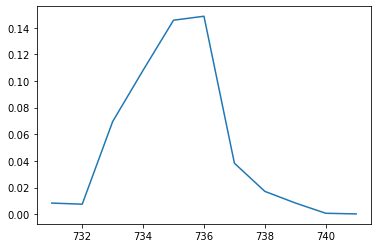

In [26]:
fig, ax = plt.subplots()

ax.plot(times_1, thread_1_af_values)


This feels exciting. Let's get the rest of the threads

In [27]:
thread_2_af = dict()

for event in overlapped_2015[1]:
    time = list(event.keys())[0]

    event_usdm = np.array(event[time])[:, 0]
    coords_usdm = np.vstack([node.coords for node in event_usdm])
    coord_set_usdm = set(tuple(coord) for coord in coords_usdm)

    event_pdsi = np.array(event[time])[:, 1]
    coords_pdsi = np.vstack([node.coords for node in event_pdsi])
    coord_set_pdsi = set(tuple(coord) for coord in coords_pdsi)

    coord_set_intersect = coord_set_usdm.intersection(coord_set_pdsi)
    coord_set_union = coord_set_usdm.union(coord_set_pdsi)

    thread_2_af[time] = len(coord_set_intersect)/len(coord_set_union)


In [28]:
times_2 = list(thread_2_af.keys())
thread_2_af_values = np.array(list(thread_2_af.values()))


In [29]:
thread_3_af = dict()

for event in overlapped_2015[2]:
    time = list(event.keys())[0]

    event_usdm = np.array(event[time])[:, 0]
    coords_usdm = np.vstack([node.coords for node in event_usdm])
    coord_set_usdm = set(tuple(coord) for coord in coords_usdm)

    event_pdsi = np.array(event[time])[:, 1]
    coords_pdsi = np.vstack([node.coords for node in event_pdsi])
    coord_set_pdsi = set(tuple(coord) for coord in coords_pdsi)

    coord_set_intersect = coord_set_usdm.intersection(coord_set_pdsi)
    coord_set_union = coord_set_usdm.union(coord_set_pdsi)

    thread_3_af[time] = len(coord_set_intersect)/len(coord_set_union)


In [30]:
times_3 = list(thread_3_af.keys())
thread_3_af_values = np.array(list(thread_3_af.values()))


Can optimize this in a bit

Text(0, 0.5, 'Alignment Fraction')

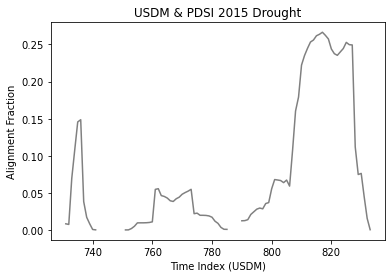

In [31]:
fig, ax = plt.subplots()

ax.plot(times_1, thread_1_af_values, color='grey')

ax.plot(times_2, thread_2_af_values, color='grey')

ax.plot(times_3, thread_3_af_values, color='grey')

ax.set_title('USDM & PDSI 2015 Drought')
ax.set_xlabel('Time Index (USDM)')
ax.set_ylabel('Alignment Fraction')

I feel like this should be much higher ... like during the peak of the 2015 drought it should be like 0.9 or something ...

I wonder if there is a difference in spatial resolution?

In [32]:
usdm

<xarray.Dataset>
Dimensions:  (lat: 139, lon: 314, date: 1163)
Coordinates:
  * lat      (lat) float64 49.0 48.97 48.95 48.92 ... 45.62 45.6 45.57 45.55
  * lon      (lon) float64 -124.7 -124.7 -124.7 -124.7 ... -117.0 -116.9 -116.9
  * date     (date) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    USDM     (date, lat, lon) float64 ...
Attributes:
    compilation:  a. stein, 6/8/2022
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:4326
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to Washington using http://eric.c...

In [33]:
pdsi

<xarray.Dataset>
Dimensions:  (lat: 84, lon: 188, day: 1149)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
Data variables:
    crs      int64 ...
    pdsi     (day, lat, lon) float32 ...
Attributes:
    author:       a. stein, 7/28/2022
    description:  Palmer Drought Severity Index (PDSI) gathered from various ...
    clipping:     Clipped to Washington state using http://eric.clst.org/asse...

Ah, yeah ... there is a difference in spatial resolution. We need to resolve that first. PDSI is much coarser ... which means less pixels will be nabbed as overlapping :eyeroll:

In [34]:
pdsi_net.data.shape

(1149, 84, 188)

In [35]:
usdm_net.data.shape

(1163, 139, 314)

I'll go ahead and keep this error on my part in the notebook as a reminder and work on abstracting into a function

### Attempt 2: Actually Spatially Matching

In [36]:
matched_dates

,PDSI,USDM Date
0,1999-12-31,2000-01-04 00:00:00
1,2000-01-10,2000-01-11 00:00:00
2,2000-01-15,2000-01-18 00:00:00
3,2000-01-25,2000-01-25 00:00:00
4,2000-01-30,2000-02-01 00:00:00
...,...,...
1144,2021-12-06,2021-12-07 00:00:00
1145,2021-12-11,2021-12-14 00:00:00
1146,2021-12-21,2021-12-21 00:00:00
1147,2021-12-26,2021-12-28 00:00:00


In [37]:
pdsi['pdsi']

<xarray.DataArray 'pdsi' (day: 1149, lat: 84, lon: 188)>
[18145008 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31
Attributes:
    units:              
    description:        Palmer Drought Severity Index
    long_name:          pdsi
    standard_name:      pdsi
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    Clipping:           original data was clipped to Washington using http://...
    grid_mapping:       crs

In [38]:
usdm_pdsi_paired_ds = compare.create_paired_ds(
    [usdm['USDM'].sel(date=matched_dates['USDM Date'].values).rio.write_crs('EPSG:4326', inplace=True)], 
    [pdsi['pdsi'].sel(day=matched_dates['PDSI'].values).rio.write_crs('EPSG:4326', inplace=True)], 
    matched_dates['USDM Date'], 
    matched_dates['PDSI'], rescale=True)
usdm_pdsi_paired_ds

<xarray.Dataset>
Dimensions:         (index: 1149, lat: 84, lon: 188)
Coordinates:
  * index           (index) int64 0 1 2 3 4 5 ... 1143 1144 1145 1146 1147 1148
  * lat             (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon             (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
Data variables:
    USDM            (index, lat, lon) float64 nan nan nan nan ... nan nan nan
    USDM DATE Date  (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-01-04
    pdsi            (index, lat, lon) float32 nan nan nan nan ... nan nan nan
    PDSI Date       (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-31

(array([9195067.,       0., 1714527.,       0., 1703830.,       0.,
         852093.,       0.,  499187.,  374816.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

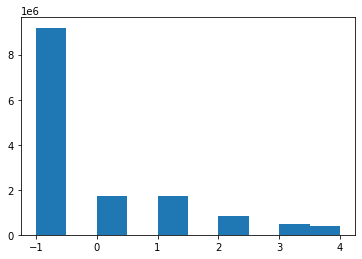

In [39]:
# check I didn't mess anything up
plt.hist(usdm_pdsi_paired_ds['pdsi'].values.ravel())

Okay, let's make drought networks off the spatially paired now

In [40]:
sys.setrecursionlimit(int(1e4))

In [41]:
#pdsi_net = dnet.DroughtNetwork(data=usdm_pdsi_paired_ds['pdsi'].values, name='PDSI (USDM Match)')
#pdsi_net.pickle(f'{dm_path}/ndrought_products/paired_dnet/pdsi_net_usdm_match.pickle')

pdsi_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/ndrought_products/paired_dnet/pdsi_net_usdm_match.pickle')

In [42]:
#usdm_net = dnet.DroughtNetwork(data=usdm_pdsi_paired_ds['USDM'].values, name='USDM (PDSI Match)')
#usdm_net.pickle(f'{dm_path}/ndrought_products/paired_dnet/usdm_net_pdsi_match.pickle')

usdm_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/ndrought_products/paired_dnet/usdm_net_pdsi_match.pickle')

In [43]:
overlap_events = usdm_net.find_overlapping_nodes_events(pdsi_net, matched_dates_dict)

  0%|          | 0/55411743 [00:00<?, ?it/s]

In [65]:
i = 0
start_found = False
end_found = False
overlapped_2015 = []
while i < len(overlap_events) and not (start_found & end_found):
    thread_start = list(overlap_events[i][0].keys())[0]
    thread_end = list(overlap_events[i][-1].keys())[0]
    if thread_start >= usdm_2015_times[0]:
        start_found = True
    
        if thread_end <= usdm_2015_times[-1]:
            overlapped_2015.append(overlap_events[i])
        else:
            end_found = True       
    i += 1

In [66]:
print('Threads overlapping during 2015 drought = ', len(overlapped_2015))
overlapped_2015

Threads overlapping during 2015 drought =  1


[[{731: [[time: 731, id: 559, time: 731, id: 24543],
    [time: 731, id: 559, time: 731, id: 24545],
    [time: 731, id: 559, time: 731, id: 24546],
    [time: 731, id: 559, time: 731, id: 24547],
    [time: 731, id: 559, time: 731, id: 24548],
    [time: 731, id: 559, time: 731, id: 24549],
    [time: 731, id: 559, time: 731, id: 24550],
    [time: 731, id: 559, time: 731, id: 24551],
    [time: 731, id: 559, time: 731, id: 24554],
    [time: 731, id: 559, time: 731, id: 24560]]},
  {732: [[time: 732, id: 563, time: 732, id: 24561],
    [time: 732, id: 563, time: 732, id: 24564],
    [time: 732, id: 563, time: 732, id: 24565],
    [time: 732, id: 563, time: 732, id: 24566],
    [time: 732, id: 563, time: 732, id: 24567],
    [time: 732, id: 563, time: 732, id: 24568],
    [time: 732, id: 563, time: 732, id: 24569],
    [time: 732, id: 563, time: 732, id: 24570],
    [time: 732, id: 563, time: 732, id: 24571],
    [time: 732, id: 563, time: 732, id: 24572],
    [time: 732, id: 563, tim

In [67]:
def compute_alignment_fraction(overlap_events):

    net_af = []

    for thread in overlap_events:
        thread_af = dict()

        for event in thread:
            time = list(event.keys())[0]

            event_a = np.array(event[time])[:, 0]
            coords_a = np.vstack([node.coords for node in event_a])
            coord_set_a = set(tuple(coord) for coord in coords_a)

            event_b = np.array(event[time])[:, 1]
            coords_b = np.vstack([node.coords for node in event_b])
            coord_set_b = set(tuple(coord) for coord in coords_b)

            coord_set_intersect = coord_set_a.intersection(coord_set_b)
            coord_set_union = coord_set_a.union(coord_set_b)

            thread_af[time] = len(coord_set_intersect)/len(coord_set_union)
    
        net_af.append(thread_af)

    return net_af

In [68]:
usdm_pdsi_af = compute_alignment_fraction(overlapped_2015)

In [69]:
len(usdm_pdsi_af)

1

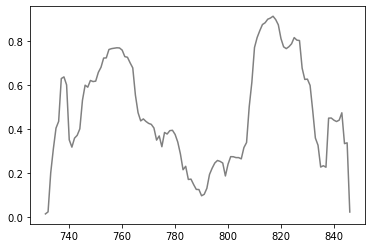

In [70]:
fig, ax = plt.subplots()

times = list(usdm_pdsi_af[0].keys())
af_values = np.array(list(usdm_pdsi_af[0].values()))

ax.plot(times, af_values, color='grey')

Ah, okay, that is fine with me that the last overlapping event is where pdsi is going to do something else

In [72]:
import matplotlib.dates as mdates

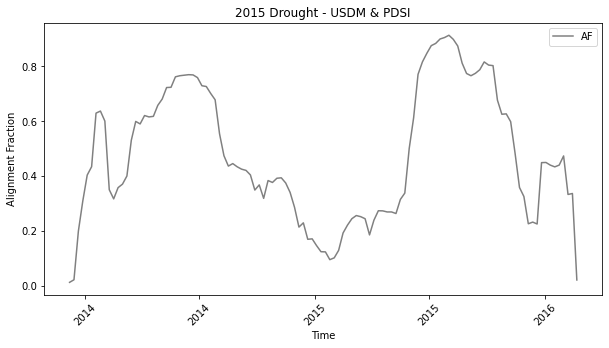

In [73]:
fig, ax = plt.subplots(figsize=(10,5))

usdm_dates = usdm_pdsi_paired_ds['USDM DATE Date'].values[times]

times = list(usdm_pdsi_af[0].keys())
af_values = np.array(list(usdm_pdsi_af[0].values()))

ax.plot(usdm_dates, af_values, color='grey', label='AF')

ax.set_xlabel('Time')
ax.set_ylabel('Alignment Fraction')
ax.set_title('2015 Drought - USDM & PDSI')

# fix the formating to only show hours
formatter = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(formatter)
# set the frequency to not crowd the axis
ax.set_xticks(pd.date_range(usdm_dates[0], usdm_dates[-1], freq='6M'))
ax.tick_params(axis='x', rotation=45)

fig.set_facecolor('w')

ax.legend()

Hazah! That worked! I'm so excited

That got put into `drought_network.py` now

In [74]:
usdm_pdsi_af = compute_alignment_fraction(overlap_events)

In [75]:
times = []
af_values = []

for thread_af in usdm_pdsi_af:
    times.append(list(thread_af.keys()))
    af_values.append(list(thread_af.values()))

times = np.hstack(times)
af_values = np.hstack(af_values)


In [76]:
usdm_dates = usdm_pdsi_paired_ds['USDM DATE Date'].values[times]

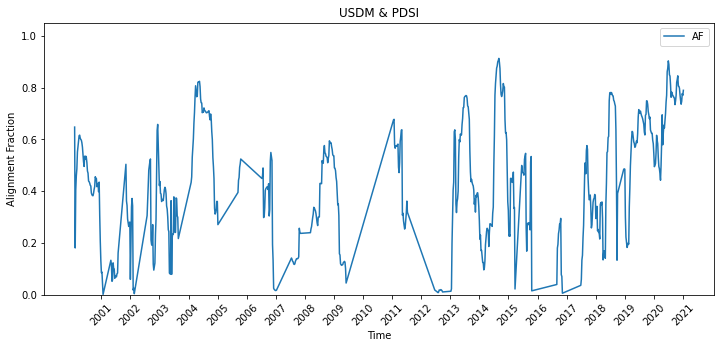

In [77]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(usdm_dates, af_values, label='AF')

ax.set_ylim(0, 1.05)

ax.set_xlabel('Time')
ax.set_ylabel('Alignment Fraction')
ax.set_title('USDM & PDSI')

# fix the formating to only show hours
formatter = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(formatter)
# set the frequency to not crowd the axis
ax.set_xticks(pd.date_range(usdm_dates[0], usdm_dates[-1], freq='1y'))
ax.tick_params(axis='x', rotation=45)

fig.set_facecolor('w')

ax.legend()
#ax.axhline(1, linestyle='--')

Will need to think on best plotting way cause I don't want there to be lines connecting them inbetween threads. This is interesting to me though to see that there are some droughts that are captured pretty similar between USDM and SPI, but then there's something else happening in the late 00's where the area of PDSI that touches USDM is much greater than that USDM area

## Disagreement Fraction (DF)

Okay, so here I want to now gather all the nodes that did NOT overlap.

First I need to parse out which did overlap then I can select the others.

In [78]:
times = []
usdm_overlapped_2015 = []
pdsi_overlapped_2015 = []

for event in overlapped_2015[0]:
    time = list(event.keys())[0]

    event_usdm = np.array(event[time])[:, 0]
    event_pdsi = np.array(event[time])[:, 1]

    times.append(time)
    usdm_overlapped_2015.append(event_usdm)
    pdsi_overlapped_2015.append(event_pdsi)

usdm_overlapped_2015 = np.hstack(usdm_overlapped_2015)
pdsi_overlapped_2015 = np.hstack(pdsi_overlapped_2015)

In [91]:
usdm_2015_nodes = usdm_net.get_chronological_future_thread(id=893)

In [80]:
pdsi_2015_nodes = pdsi_net.time_slice(728, 848)

In [81]:
usdm_not_overlapped_2015 = dict()

for node in usdm_2015_nodes:
    if node not in usdm_overlapped_2015:
        time = node.time
        if time not in usdm_not_overlapped_2015.keys():
            usdm_not_overlapped_2015[time] = []
        
        usdm_not_overlapped_2015[time].append(node)

In [85]:
pdsi_not_overlapped_2015 = dict()

for node in pdsi_2015_nodes:
    if node not in pdsi_overlapped_2015:
        time = node.time
        if time not in pdsi_not_overlapped_2015.keys():
            pdsi_not_overlapped_2015[time] = []
        
        pdsi_not_overlapped_2015[time].append(node)

In [88]:
usdm_2015_nodes_timesort = dict()

for node in usdm_2015_nodes:
    time = node.time

    if time not in usdm_2015_nodes_timesort.keys():
        usdm_2015_nodes_timesort[time] = []

    usdm_2015_nodes_timesort[time].append(node)

In [89]:
pdsi_2015_nodes_timesort = dict()

for node in pdsi_2015_nodes:
    time = node.time

    if time not in pdsi_2015_nodes_timesort.keys():
        pdsi_2015_nodes_timesort[time] = []

    pdsi_2015_nodes_timesort[time].append(node)

In [ ]:
for time in usdm_not_overlapped_2015.keys():
    all_nodes = usdm_2015_nodes_timesort
    not_overlapped_nodes = usdm_not_overlapped_2015[time]

    not_overlapped_area = 0

    for node in not_overlapped_nodes:
        not_overlapped_area += len(node.coords)

    